# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.2.0-56-gcd6bb-dirty
[  0%] Built target get_version
[  8%] Built target parpecommon
[ 17%] Built target parpeoptimization
[ 20%] Built target parpeloadbalancer
[ 31%] Built target parpeamici
[ 32%] Built target parpe
[ 37%] Built target unittests_common
[ 40%] Built target unittests_loadbalancer
[ 44%] Built target unittests_optimization_ipopt
[ 54%] Built target unittests_optimization
[ 58%] Built target unittests_optimization_ceres
[ 59%] Creating test data using hierarchicalOptimizationTest.py
[[0 1 0]
 [0 2 0]
 [1 1 1]
 [1 2 1]
 [1 3 1]]
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 59%] Built target prepare_test_hierarchical_optimization
[ 68%] Built target unittests_amici
[ 70%] Built target example_loadbalancer
Setting up virtual environment...
Obtaining file:///home/dweindl/src/parPE_2/python
  Found existing installation: parpe 0.0.0
    Un

## Test simulation

In [3]:
# load model
sys.path.insert(0, model_source_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

[1.  0.5 0.4 2.  0.1 0.2 0.2 0.2 2.  0.2 3.  0.2 0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7f6712c44840> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],


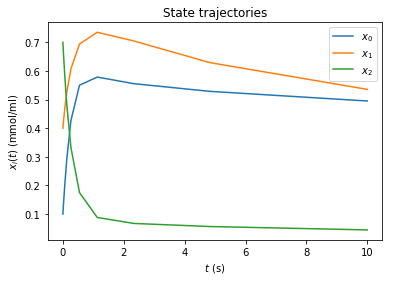

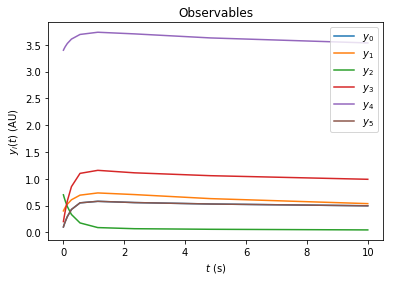

In [4]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Set parameter estimation options

Test data is:
- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [5]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test_print_all yes
!{optimizationOptionsPy} {input_file} -s numStarts 2
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {input_file}


                hierarchicalOptimization            0
                               numStarts            2
                               optimizer            0
                       retryOptimization            1
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Gradient check

In [6]:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}
    print()


[2019-02-12 14:31:00] [INF] [-1/]     0 g:     -9157.04  fd_c:     -9157.04  Δ/fd_c: -1.539155e-07  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     1 g:      827.499  fd_c:      827.501  Δ/fd_c: -3.164021e-06  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     2 g:      11274.1  fd_c:      11274.1  Δ/fd_c: 1.220437e-07  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     3 g:     -1689.87  fd_c:     -1689.86  Δ/fd_c: 1.524077e-06  f:      41168.7
[2019-02-12 14:31:00] [WRN] [-1/]     4 g:    -0.153345  fd_c:    -0.149157  Δ/fd_c: 2.808125e-02  f:      41168.7
[2019-02-12 14:31:00] [WRN] [-1/]     5 g:    -0.226698  fd_c:    -0.226646  Δ/fd_c: 2.296952e-04  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     6 g:            0  fd_c:            0  Δ/fd_c: 0.000000e+00  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     7 g:      184.207  fd_c:      184.207  Δ/fd_c: -1.471603e-06  f:      41168.7
[2019-02-12 14:31:00] [INF] [-1/]     8 g:            0  fd_c:            0  

## Optimize

In [7]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


/home/dweindl/src/parPE_2/examples/parpeamici/steadystate
[  1%] Creating test data using hierarchicalOptimizationTest.py
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  9%] Built target parpecommon
Setting up virtual environment...
-- Building version parPE-v0.2.0-56-gcd6bb-dirty
[  9%] Built target get_version
[ 12%] Built target parpeloadbalancer
[ 17%] Built target unittests_common
[ 27%] Built target parpeoptimization
[ 29%] Built target example_loadbalancer
[ 32%] Built target unittests_loadbalancer
[ 41%] Built target unittests_optimization
[[0 1 0]
 [0 2 0]
 [1 1 1]
 [1 2 1]
 [1 3 1]]
[ 45%] Built target unittests_optimization_ipopt
...
----------------------------------------------------------------------
[ 56%] Built target parpeamici
Ran 3 tests in 0.001s

OK
[ 60%] Built target unittests_optimization_ceres
[ 61%] Built target parpe
[ 61%] Built target prepare_test_hierarchical_optimization
[ 70%] Built target unittests_amici
Obtaining file:///home/dweindl/src/parPE_

[2019-02-12 14:31:04] [INF] [-1/] [o0i9] iter: 9 cost: 20364.2 time_iter: wall: 0.0675861s cpu: 0.0592387s time_optim: wall: 0.686937s cpu: 0.600357s
   9  2.0364248e+04 0.00e+00 3.78e-04  -8.6 8.97e-02    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:04] [INF] [-1/] [o0i10] iter: 10 cost: 18687.5 time_iter: wall: 0.0639252s cpu: 0.0565674s time_optim: wall: 0.750862s cpu: 0.656925s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8687529e+04 0.00e+00 1.40e-04 -10.7 6.57e-02    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:04] [INF] [-1/] [o0i11] iter: 11 cost: 18298.1 time_iter: wall: 0.0666438s cpu: 0.0589758s time_optim: wall: 0.817506s cpu: 0.7159s
  11  1.8298098e+04 0.00e+00 3.76e-05 -12.3 3.99e-02    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:04] [INF] [-1/] [o0i12] iter: 12 cost: 18198.4 time_iter: wall: 0.0673678s cpu: 0.0600406s time_optim: wall: 0.884874s cpu: 0.775941s
  12  1.8198379e+04 0.00e+00 1.84e-05 -12.3 1.92e-02    -  1.00e+00 1.00

[2019-02-12 14:31:07] [INF] [-1/] [o0i42] iter: 42 cost: 14826.6 time_iter: wall: 0.0985877s cpu: 0.0908083s time_optim: wall: 3.71181s cpu: 3.34907s
  42  1.4826564e+04 0.00e+00 8.53e-08 -12.3 2.18e-02    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:07] [INF] [-1/] [o0i43] iter: 43 cost: 14826.5 time_iter: wall: 0.105111s cpu: 0.097078s time_optim: wall: 3.81692s cpu: 3.44615s
  43  1.4826516e+04 0.00e+00 1.65e-07 -12.3 8.27e-03    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:07] [INF] [-1/] [o0i44] iter: 44 cost: 14826.5 time_iter: wall: 0.122131s cpu: 0.109204s time_optim: wall: 3.93905s cpu: 3.55535s
  44  1.4826513e+04 0.00e+00 3.06e-07 -12.3 9.40e-03    -  1.00e+00 2.50e-01f  3
[2019-02-12 14:31:07] [INF] [-1/] [o0i45] iter: 45 cost: 14826.5 time_iter: wall: 0.139972s cpu: 0.123066s time_optim: wall: 4.07902s cpu: 3.67842s
  45  1.4826510e+04 0.00e+00 7.84e-08 -12.3 1.39e-02    -  1.00e+00 3.12e-02f  6
[2019-02-12 14:31:08] [INF] [-1/] [o0i46] iter: 46 cost: 14826.5 time_iter: wall: 

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2019-02-12 14:31:11] [INF] [-1/] [o1i0] iter: 0 cost: 5.21216e+11 time_iter: wall: 0.0621408s cpu: 0.0529426s time_optim: wall: 0.062141s cpu: 0.0529426s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2121606e+11 0.00e+00 2.39e+04   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
[2019-02-12 14:31:11] [INF] [-1/] [o1i1] iter: 1 cost: 3.37682e+07 time_iter: wall: 0.0708124s cpu: 0.0570

[2019-02-12 14:31:14] [INF] [-1/] [o1i31] iter: 31 cost: 15484.9 time_iter: wall: 0.106075s cpu: 0.0968713s time_optim: wall: 2.61021s cpu: 2.28511s
  31  1.5484908e+04 0.00e+00 1.37e-05 -12.3 1.74e-01    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:14] [INF] [-1/] [o1i32] iter: 32 cost: 15470.6 time_iter: wall: 0.13819s cpu: 0.121361s time_optim: wall: 2.7484s cpu: 2.40648s
  32  1.5470599e+04 0.00e+00 1.13e-05 -12.3 2.19e+00    -  1.00e+00 6.25e-02f  5
[2019-02-12 14:31:14] [INF] [-1/] [o1i33] iter: 33 cost: 15375.2 time_iter: wall: 0.104615s cpu: 0.0946121s time_optim: wall: 2.85302s cpu: 2.50109s
  33  1.5375203e+04 0.00e+00 1.52e-05 -12.3 1.25e+00    -  1.00e+00 1.00e+00f  1
[2019-02-12 14:31:14] [INF] [-1/] [o1i34] iter: 34 cost: 15285.8 time_iter: wall: 0.103813s cpu: 0.0944194s time_optim: wall: 2.95683s cpu: 2.59551s
  34  1.5285818e+04 0.00e+00 2.11e-05 -11.8 1.94e+01    -  1.00e+00 4.68e-02f  1
[2019-02-12 14:31:14] [INF] [-1/] [o1i35] iter: 35 cost: 15285.8 time_iter: wall: 0

[2019-02-12 14:31:18] [INF] [-1/] [o1i65] iter: 65 cost: 14780.1 time_iter: wall: 0.106208s cpu: 0.0966602s time_optim: wall: 6.69574s cpu: 5.90359s
  65  1.4780134e+04 0.00e+00 4.73e-06 -12.3 1.61e-01    -  1.00e+00 7.86e-01f  1
[2019-02-12 14:31:18] [INF] [-1/] [o1i66] iter: 66 cost: 14779.5 time_iter: wall: 0.139929s cpu: 0.121146s time_optim: wall: 6.83567s cpu: 6.02473s
  66  1.4779485e+04 0.00e+00 1.80e-06 -12.3 9.46e-01    -  1.00e+00 3.12e-02f  6
[2019-02-12 14:31:18] [INF] [-1/] [o1i67] iter: 67 cost: 14774.6 time_iter: wall: 0.120329s cpu: 0.106639s time_optim: wall: 6.956s cpu: 6.13137s
  67  1.4774583e+04 0.00e+00 1.09e-06 -12.3 1.84e-01    -  1.00e+00 5.00e-01f  2
[2019-02-12 14:31:18] [INF] [-1/] [o1i68] iter: 68 cost: 14773.7 time_iter: wall: 0.127101s cpu: 0.112404s time_optim: wall: 7.0831s cpu: 6.24377s
  68  1.4773659e+04 0.00e+00 6.04e-07 -12.3 1.48e-01    -  1.00e+00 2.50e-01f  3
[2019-02-12 14:31:18] [INF] [-1/] [o1i69] iter: 69 cost: 14773.5 time_iter: wall: 0.12

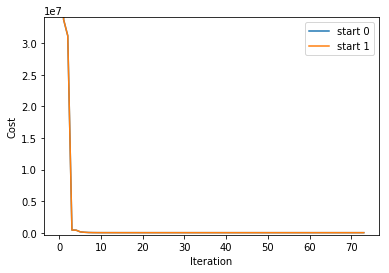

In [8]:
filename = 'deleteme/_rank-0001.h5'
trajectories = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories, log=False);

## Compare results

In [43]:
def compareResults(filename):
    with h5py.File(filename, 'r') as f:
        pscale = f['/inputData/parameters/pscale'][:]
        names = f['/inputData/parameters/parameterNames'][:]
        true_parameters = f['/inputData/parameters/true_parameters'][:]
        expectedNllh = -f['/inputData/parameters/true_llh'][:]
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %9.5f %11.5f %11.5f %11.5f %s' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error, names[i]))
    print()
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [44]:
compareResults('deleteme/_rank-0001.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000   999.99954   998.99954   998.99954 p1
1:   0.50000   220.06530   219.56530   439.13060 p2
2:   0.40000    87.82024    87.42024   218.55061 p3
3:   2.00000   999.99977   997.99977   498.99988 p4
4:   0.10000     0.47929     0.37929     3.79291 p5
5:   2.00000     1.69383    -0.30617    -0.15308 scaling_x1_common
6:   3.00000     0.39500    -2.60500    -0.86833 offset_x2_batch-0
7:   0.20000     0.25348     0.05348     0.26739 x1withsigma_sigma
8:   4.00000  -248.87775  -252.87775   -63.21944 offset_x2_batch-1

Status: 4
Cost: 14773.428344 (expected: -0.000000)


In [45]:
# Simulate with optimal parameters, save results
!rm sim.h5
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4
Running for start 1
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [46]:
# Load simulated outputs
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    timepoints = f['/inputData/amiciOptions/ts'][:]

with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
    
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


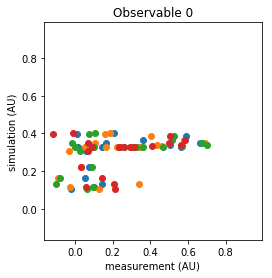

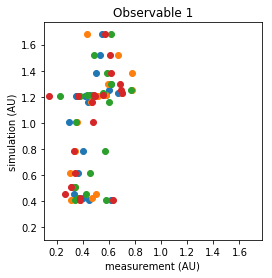

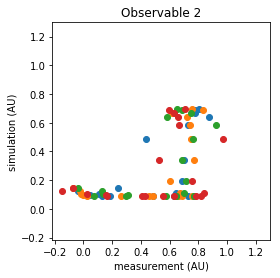

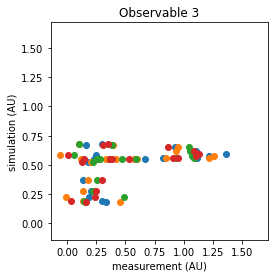

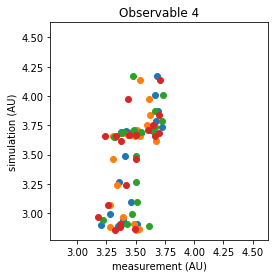

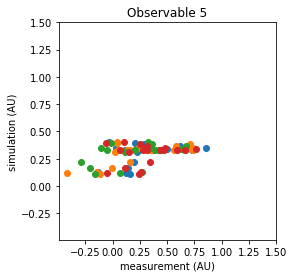

In [47]:
parpe.plotting.plotCorrelations(ymes, ysim)

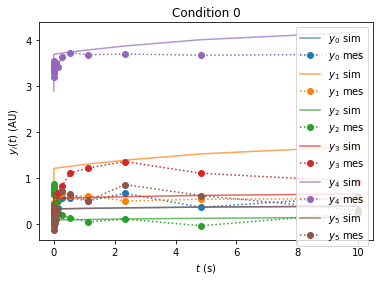

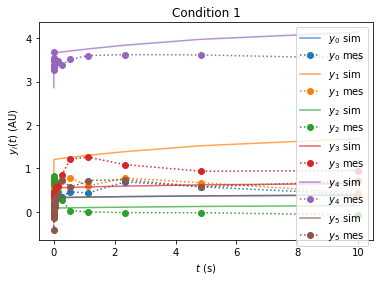

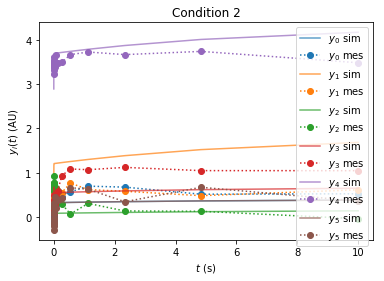

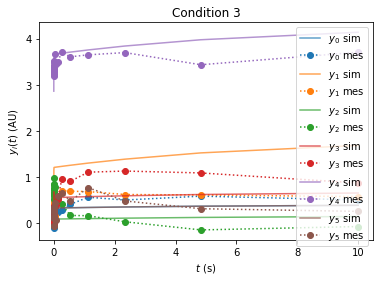

In [48]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Hierarchical optimization

In [61]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 20
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [62]:
# gradient check 
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}


HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
[2019-02-12 15:12:25] [WRN] [-1/]     0 g:      2678.79  fd_c:      2693.47  Δ/fd_c: -5.450913e-03  f:       111433
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
[2019-02-12 15:12:25] [WRN] [-1/]     1 g:     -752.402  fd_c:     -752.611  Δ/fd_c: -2.774337e-04  f:       111433
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
[2019-02-12 15:12:25] [WRN] [-1/]     2 g:     -2076.33  fd_c:     -2083.94  Δ/fd_c: -3.652232e-03  f:       111433
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
[2019-02-12 15:12:25] [WRN] [-1/]     3 g:      3486.53  fd_c:      3487.04  Δ/fd_c: -1.482038e-04  f:       111433
scalings [ 0.701094 ]
sigmas [ -0.562854 ]
sca

In [63]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-02-12 15:12:25] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-02-12 15:12:25] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
 

scalings [ 0.324657 ]
sigmas [ -0.674506 ]
scalings [ 0.324657 ]
sigmas [ -0.674506 ]
scalings [ 0.317276 ]
sigmas [ -0.673176 ]
scalings [ 0.31342 ]
sigmas [ -0.672359 ]
scalings [ 0.31145 ]
sigmas [ -0.67191 ]
scalings [ 0.31145 ]
sigmas [ -0.67191 ]
[2019-02-12 15:12:27] [INF] [0/dweindl] [o0i14] iter: 14 cost: -388.41 time_iter: wall: 0.129169s cpu: 0.220403s time_optim: wall: 1.36805s cpu: 2.6763s
  14 -3.8841049e+02 0.00e+00 4.19e-01 -11.0 9.94e-02    -  1.00e+00 1.25e-01f  4
scalings [ 0.31099 ]
sigmas [ -0.671876 ]
scalings [ 0.31099 ]
sigmas [ -0.671876 ]
[2019-02-12 15:12:27] [INF] [0/dweindl] [o0i15] iter: 15 cost: -388.423 time_iter: wall: 0.0675672s cpu: 0.169602s time_optim: wall: 1.43562s cpu: 2.8459s
  15 -3.8842316e+02 0.00e+00 1.44e-01 -11.0 2.32e-02    -  1.00e+00 1.00e+00f  1
scalings [ 0.310611 ]
sigmas [ -0.670914 ]
scalings [ 0.310611 ]
sigmas [ -0.670914 ]
scalings [ 0.310684 ]
sigmas [ -0.671403 ]
scalings [ 0.310805 ]
sigmas [ -0.671641 ]
scalings [ 0.310889 ]

array([[-213.80269105, -328.51661943, -370.61659559, -380.38079953,
        -387.01689308, -387.22995024, -387.26051794, -387.74402106,
        -388.12906724, -388.13732576, -388.36063589, -388.36199392,
        -388.40475061, -388.41028903, -388.41048696, -388.42315861,
        -388.42371214, -388.42471389, -388.42478915, -388.42500482,
        -388.42505485]])

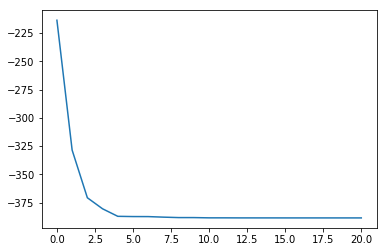

In [64]:
filename = hdf5_pe_output_file_hierarchical
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [65]:
compareResults(hdf5_pe_output_file_hierarchical)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.27823    -0.72177    -0.72177 p1
1:   0.50000     0.72835     0.22835     0.45669 p2
2:   0.40000     0.07498    -0.32502    -0.81254 p3
3:   2.00000     2.40279     0.40279     0.20139 p4
4:   0.10000     0.10722     0.00722     0.07220 p5
5:   2.00000     2.04864     0.04864     0.02432 scaling_x1_common
6:   3.00000     3.00264     0.00264     0.00088 offset_x2_batch-0
7:   0.20000     0.21280     0.01280     0.06398 x1withsigma_sigma
8:   4.00000     2.99753    -1.00247    -0.25062 offset_x2_batch-1

Status: 1
Cost: -388.425055 (expected: -0.000000)


In [67]:
!rm simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

rm: cannot remove 'simh.h5': No such file or directory
Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [68]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


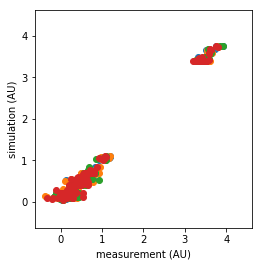

In [69]:
parpe.plotting.plotCorrelation(ymes, ysim)

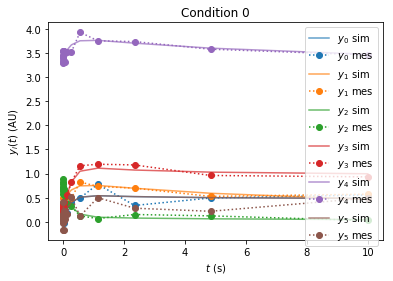

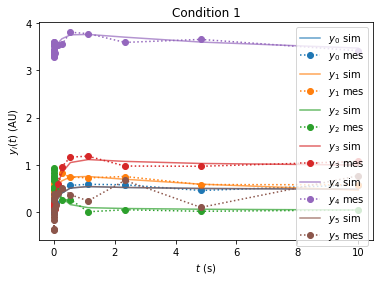

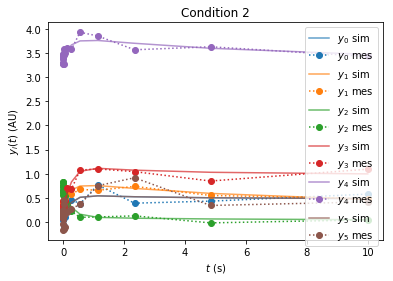

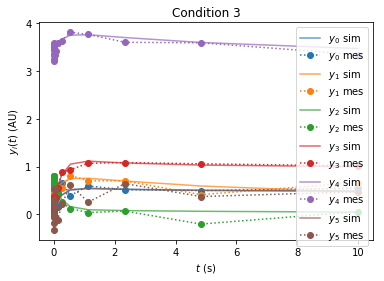

In [70]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Ceres

In [71]:
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres}


[2019-02-12 19:48:35] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-02-12 19:48:35] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ 0.18787 ]
sigmas [ -0.604581 ]
callbacks.cc:105    0: f:-2.138027e+02 d: 0.00e+00 g: 5.33e+02 h: 0.00e+00 s: 0.00e+00 e:  0 it: 5.25e-02 tt: 5.25e-02
[2019-02-12 19:48:35] [INF] [0/dweindl] [o0i0] iter: 0 cost: -213.803 time_iter: wall: 0.0535686s cpu: 0.152385s time_optim: wall: 0.053569s cpu

In [72]:
compareResults('deletemeceres/_rank00000.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.27791    -0.72209    -0.72209 p1
1:   0.50000     0.72792     0.22792     0.45585 p2
2:   0.40000     0.07492    -0.32508    -0.81270 p3
3:   2.00000     2.40290     0.40290     0.20145 p4
4:   0.10000     0.10711     0.00711     0.07112 p5
5:   2.00000     2.04858     0.04858     0.02429 scaling_x1_common
6:   3.00000     3.00263     0.00263     0.00088 offset_x2_batch-0
7:   0.20000     0.21280     0.01280     0.06398 x1withsigma_sigma
8:   4.00000     2.99752    -1.00248    -0.25062 offset_x2_batch-1

Status: 0
Cost: -388.425062 (expected: -0.000000)


## Minibatch optimization

In [74]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'
!cp {example_data_dir}/example_data.h5 {hdf5FileMinibatch}

!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10 # minibatch
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [75]:
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Creating starting point backup in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [76]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-02-12 19:50:01] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-02-12 19:50:01] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-02-12 19:50:01] [WRN] [0/dweindl] Ignoring unknown optimization option Vanilla-learningRate.
[2019-02-12 19:50:01] [INF] [0/dweindl] [o0e0b1] iter: 0 cost: 5146.3 time_iter: wall: 0.0681766s cpu: 0.0946921s time_optim: wall: 0.0681769s cpu: 0.0946921s
[2019-02-12 19:50:01] [INF] [0/dweindl] [o0e1b1] iter: 1 cost: 2557.34 time_iter: wall: 0.0572755s cpu: 0.0924248s time_optim: wall: 0.125453s cpu: 0.187117s
[2019-02-12 19:50:01] [INF] [0/dweindl] [o0e2b1] iter: 2 cost: 1503.44 time_iter: wall: 0.0421724s cpu: 0.0750198s time_optim: wall: 0.167625s cpu: 0.262137s
[2019-02-12 19:50:01] [INF] [0/dweindl] [o0e3b1] iter: 3 cost: 710.598 time_iter: wall: 0.0520575s cpu: 0.0858548s time_optim: wall: 0.219683s cpu: 0.347992s
[2019-02-12 19:50:01] [INF] [0/dweindl] [o0e4b1] iter: 4 cost: 408.82 time_iter: wall: 0

[2019-02-12 19:50:03] [INF] [0/dweindl] [o0e48b1] iter: 48 cost: -94.4243 time_iter: wall: 0.0719444s cpu: 0.108316s time_optim: wall: 2.59694s cpu: 4.21879s
[2019-02-12 19:50:03] [INF] [0/dweindl] [o0e49b1] iter: 49 cost: -98.6101 time_iter: wall: 0.082544s cpu: 0.107283s time_optim: wall: 2.67948s cpu: 4.32607s
[2019-02-12 19:50:04] [INF] [0/dweindl] [o0] Number of epochs exceeded.
[2019-02-12 19:50:04] [INF] [0/dweindl] [o0] Optimizer status 1, final llh: -9.655886e+01, time: wall: 2.730929 cpu: 4.414056.
[2019-02-12 19:50:05] [INF] [0/dweindl] Walltime on master: 4.172492s, CPU time of all processes: 14.378498s
[2019-02-12 19:50:05] [INF] [0/dweindl] Sent termination signal to workers.


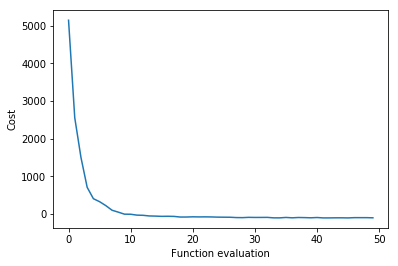

In [77]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [78]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

[2019-02-12 19:50:08] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-02-12 19:50:08] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-02-12 19:50:08] [WRN] [0/dweindl] Ignoring unknown optimization option Vanilla-learningRate.
[2019-02-12 19:50:08] [INF] [0/dweindl] [o0e0b1] iter: 0 cost: 4848.69 time_iter: wall: 0.068069s cpu: 0.0826366s time_optim: wall: 0.0680693s cpu: 0.0826366s
[2019-02-12 19:50:08] [INF] [0/dweindl] [o0e1b1] iter: 1 cost: 1769.61 time_iter: wall: 0.0434614s cpu: 0.0756475s time_optim: wall: 0.111531s cpu: 0.158284s
[2019-02-12 19:50:08] [INF] [0/dweindl] [o0e2b1] iter: 2 cost: 1049.45 time_iter: wall: 0.0509515s cpu: 0.0757468s time_optim: wall: 0.162483s cpu: 0.234031s
[2019-02-12 19:50:08] [INF] [0/dweindl] [o0e3b1] iter: 3 cost: 575.789 time_iter: wall: 0.050081s cpu: 0.0814682s time_optim: wall: 0.212564s cpu: 0.315499s
[2019-02-12 19:50:08] [INF] [0/dweindl] [o0e4b1] iter: 4 cost: 481.194 time_iter: wall: 0

[2019-02-12 19:50:10] [INF] [0/dweindl] [o0e48b1] iter: 48 cost: -93.2673 time_iter: wall: 0.0543196s cpu: 0.0918426s time_optim: wall: 2.55031s cpu: 4.07968s
[2019-02-12 19:50:10] [INF] [0/dweindl] [o0e49b1] iter: 49 cost: -98.6346 time_iter: wall: 0.0464239s cpu: 0.0786784s time_optim: wall: 2.59674s cpu: 4.15836s
[2019-02-12 19:50:10] [INF] [0/dweindl] [o0] Number of epochs exceeded.
[2019-02-12 19:50:10] [INF] [0/dweindl] [o0] Optimizer status 1, final llh: -9.656150e+01, time: wall: 2.646495 cpu: 4.270867.
[2019-02-12 19:50:12] [INF] [0/dweindl] Walltime on master: 4.165174s, CPU time of all processes: 13.774803s
[2019-02-12 19:50:12] [INF] [0/dweindl] Sent termination signal to workers.
[2019-02-12 19:50:13] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-02-12 19:50:13] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-02-12 19:50:13] [WRN] [0/dweindl] Ignoring unknown optimization option Vanilla-learningRate.
[2019-02-12 19:50:1

[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e43b1] iter: 43 cost: -98.421 time_iter: wall: 0.0492718s cpu: 0.0867273s time_optim: wall: 2.05869s cpu: 3.53805s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e44b1] iter: 44 cost: -99.0999 time_iter: wall: 0.0483452s cpu: 0.08554s time_optim: wall: 2.10704s cpu: 3.62359s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e45b1] iter: 45 cost: -92.9424 time_iter: wall: 0.0545576s cpu: 0.0926641s time_optim: wall: 2.1616s cpu: 3.71626s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e46b1] iter: 46 cost: -101.315 time_iter: wall: 0.0559435s cpu: 0.0931287s time_optim: wall: 2.21754s cpu: 3.80939s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e47b1] iter: 47 cost: -99.5681 time_iter: wall: 0.0543504s cpu: 0.0898202s time_optim: wall: 2.27189s cpu: 3.89921s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e48b1] iter: 48 cost: -101.427 time_iter: wall: 0.046411s cpu: 0.0813255s time_optim: wall: 2.3183s cpu: 3.98053s
[2019-02-12 19:50:15] [INF] [0/dweindl] [o0e49b1] it

[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e38b1] iter: 38 cost: -98.1368 time_iter: wall: 0.051728s cpu: 0.0840258s time_optim: wall: 1.99703s cpu: 3.1765s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e39b1] iter: 39 cost: -92.6608 time_iter: wall: 0.0500159s cpu: 0.0870383s time_optim: wall: 2.04705s cpu: 3.26354s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e40b1] iter: 40 cost: -92.8364 time_iter: wall: 0.0522005s cpu: 0.0916314s time_optim: wall: 2.09925s cpu: 3.35517s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e41b1] iter: 41 cost: -92.9898 time_iter: wall: 0.0500644s cpu: 0.0871508s time_optim: wall: 2.14932s cpu: 3.44232s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e42b1] iter: 42 cost: -93.1227 time_iter: wall: 0.0530592s cpu: 0.0903322s time_optim: wall: 2.20237s cpu: 3.53265s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e43b1] iter: 43 cost: -91.3507 time_iter: wall: 0.0593777s cpu: 0.0880018s time_optim: wall: 2.26175s cpu: 3.62066s
[2019-02-12 19:50:20] [INF] [0/dweindl] [o0e44b1

[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e33b1] iter: 33 cost: -97.3108 time_iter: wall: 0.0879418s cpu: 0.123359s time_optim: wall: 3.13605s cpu: 4.21515s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e34b1] iter: 34 cost: -97.5395 time_iter: wall: 0.0863775s cpu: 0.117656s time_optim: wall: 3.22243s cpu: 4.33281s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e35b1] iter: 35 cost: -89.93 time_iter: wall: 0.0875809s cpu: 0.116959s time_optim: wall: 3.31001s cpu: 4.44977s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e36b1] iter: 36 cost: -90.2597 time_iter: wall: 0.0493947s cpu: 0.0865714s time_optim: wall: 3.3594s cpu: 4.53634s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e37b1] iter: 37 cost: -98.0503 time_iter: wall: 0.0547123s cpu: 0.0906544s time_optim: wall: 3.41411s cpu: 4.62699s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e38b1] iter: 38 cost: -90.7519 time_iter: wall: 0.0509394s cpu: 0.0880872s time_optim: wall: 3.46505s cpu: 4.71508s
[2019-02-12 19:50:26] [INF] [0/dweindl] [o0e39b1] it

[2019-02-12 19:50:31] [INF] [0/dweindl] [o0e28b1] iter: 28 cost: -87.2206 time_iter: wall: 0.0642707s cpu: 0.10009s time_optim: wall: 2.10559s cpu: 3.07288s
[2019-02-12 19:50:31] [INF] [0/dweindl] [o0e29b1] iter: 29 cost: -95.4401 time_iter: wall: 0.0556715s cpu: 0.0930994s time_optim: wall: 2.16126s cpu: 3.16598s
[2019-02-12 19:50:32] [INF] [0/dweindl] [o0e30b1] iter: 30 cost: -85.941 time_iter: wall: 0.0735808s cpu: 0.126471s time_optim: wall: 2.23484s cpu: 3.29245s
[2019-02-12 19:50:32] [INF] [0/dweindl] [o0e31b1] iter: 31 cost: -97.0472 time_iter: wall: 0.0651776s cpu: 0.106519s time_optim: wall: 2.30002s cpu: 3.39897s
[2019-02-12 19:50:32] [INF] [0/dweindl] [o0e32b1] iter: 32 cost: -87.6088 time_iter: wall: 0.0665589s cpu: 0.106058s time_optim: wall: 2.36658s cpu: 3.50503s
[2019-02-12 19:50:32] [INF] [0/dweindl] [o0e33b1] iter: 33 cost: -99.9019 time_iter: wall: 0.0560998s cpu: 0.0964705s time_optim: wall: 2.42268s cpu: 3.6015s
[2019-02-12 19:50:32] [INF] [0/dweindl] [o0e34b1] ite

[2019-02-12 19:50:38] [INF] [0/dweindl] [o0e23b1] iter: 23 cost: -76.1412 time_iter: wall: 0.0983914s cpu: 0.130135s time_optim: wall: 2.24607s cpu: 3.09448s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e24b1] iter: 24 cost: -92.4974 time_iter: wall: 0.106351s cpu: 0.144952s time_optim: wall: 2.35242s cpu: 3.23943s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e25b1] iter: 25 cost: -90.548 time_iter: wall: 0.110452s cpu: 0.153111s time_optim: wall: 2.46287s cpu: 3.39254s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e26b1] iter: 26 cost: -91.8783 time_iter: wall: 0.109641s cpu: 0.157831s time_optim: wall: 2.57251s cpu: 3.55037s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e27b1] iter: 27 cost: -86.5934 time_iter: wall: 0.105821s cpu: 0.157242s time_optim: wall: 2.67834s cpu: 3.70762s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e28b1] iter: 28 cost: -94.9505 time_iter: wall: 0.115492s cpu: 0.158017s time_optim: wall: 2.79383s cpu: 3.86563s
[2019-02-12 19:50:39] [INF] [0/dweindl] [o0e29b1] iter: 29

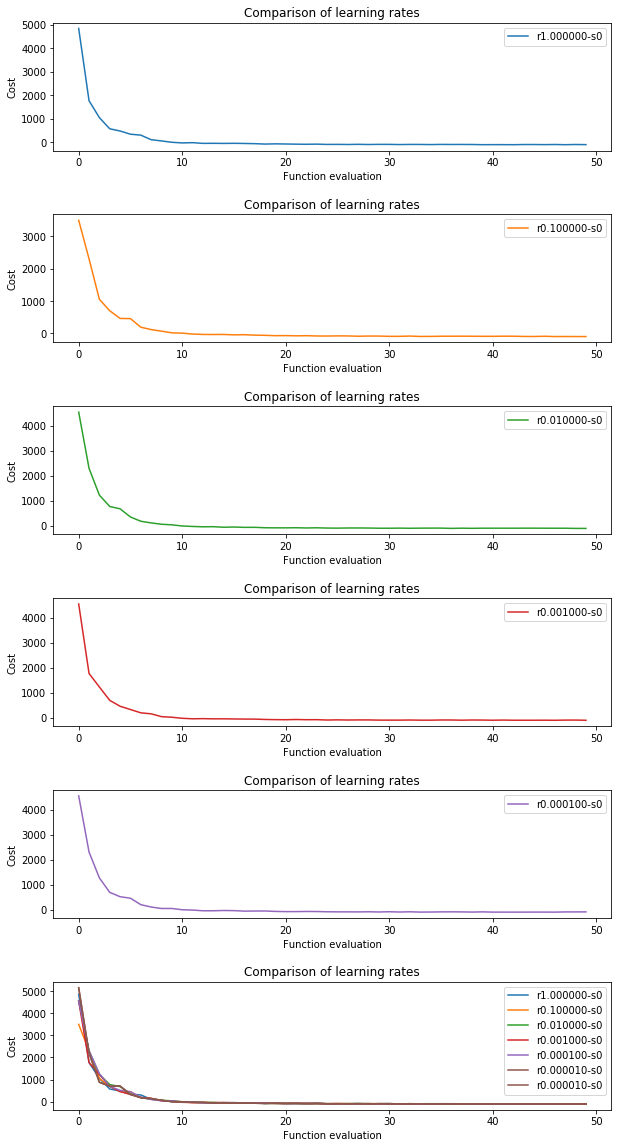

In [79]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [80]:
#?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing